In [1]:
import matplotlib.pyplot as plt

import igraph as ig
import networkx as nx
import pandas as pd
import numpy as np
import re
import swifter

from sklearn import preprocessing, model_selection
from sklearn.model_selection import cross_validate
import lightgbm as lgbm

from settings import file_names

# Datasets

In [2]:
df_reviews = pd.read_csv(file_names['toronto_reviews_without_text'])
df_users = pd.read_csv(file_names['toronto_users'])
df_biz = pd.read_csv(file_names['toronto_businesses'])

In [3]:
df_tips = pd.read_json(file_names['tip'], encoding='utf-8', lines=True)
df_tips = df_tips.loc[df_tips['user_id'].isin(df_users.user_id.unique()) & df_tips['business_id'].isin(df_biz.business_id.unique())]
print('Number of Tips: ', df_tips.shape[0])
df_tips.head(3)

Number of Tips:  33192


,user_id,business_id,text,date,compliment_count
7,CaFbX7topxdLpBJ_SNDfGQ,r49iBfbnfoK7yt4rdsL_7g,Hands down best AYCE in town! Love it!,2016-01-05 06:39:33,0
10,8zXgNCkusOHMwh5Tj_8yCQ,qrSsS0pk7SL67MP5nN8tlg,More parking in the back of the restaurant,2013-12-22 05:10:12,0
13,oIHhfloe5VQamDFDB2dr1Q,wZhB4U003eg2GQ-F7D2D4A,When you receive the bag of seafood tie it up ...,2016-08-12 22:18:07,0


In [4]:
print('Number of reviews: ',df_reviews.shape[0])
print('Ratings describe: ', df_reviews['rating'].describe())
df_reviews.head(3)



Number of reviews:  228816
Ratings describe:  count    228816.000000
mean          3.643093
std           1.139687
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


,user_id,business_id,rating,date
0,TpyOT5E16YASd7EWjLQlrw,AakkkTuGZA2KBodKi2_u8A,1.0,2012-07-16 00:37:14
1,_N7Ndn29bpll_961oPeEfw,y-Iw6dZflNix4BdwIyTNGA,3.0,2014-06-27 21:19:23
2,54kpqrxF9DEPpwa51hO_Bw,jzveTy7ogH7cg9axZ78ENg,4.0,2015-04-01 13:31:35


In [5]:
print('Number of users: ',df_users.shape[0])
df_users.head(3)

Number of users:  18804


,user_id,friends
0,gvXtMj3XuPr0xHjgmlmtng,"CfGCj80EdA-xS-mTWlAn4Q, JgD2Rk9K07MkZgG7Nb9YzA..."
1,pU6GoRTcl1rIOi6zMynjog,"SwK2Oo8sjOH0yXYVoyjJwQ, 1LpChUg-0EqRKRKzL4ogYA..."
2,AsYMm_O4H-mwmWbmeACDHw,"w-bVY-dhpvnNs8W3BTTgAA, o_OEO0ES7oywPqENQR0f3A..."


In [6]:
print('Number of businesses: ',df_biz.shape[0])
df_biz.head(3)

Number of businesses:  7965


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,attributes,categories
0,NDuUMJfrWk52RA-H-OtrpA,Bolt Fresh Bar,1170 Queen Street W,Toronto,ON,M6J 1J5,43.642889,-79.425429,3.0,57,"{'WiFi': ""u'no'"", 'BikeParking': 'True', 'Rest...","Juice Bars & Smoothies, Food, Restaurants, Fas..."
1,SP_YXIEwkFPPl_9anCYmpQ,The Steady Cafe & Bar,1051 Bloor Street W,Toronto,ON,M6H 1M4,43.660494,-79.432099,3.5,29,"{'BusinessParking': ""{'garage': False, 'street...","Restaurants, Nightlife, Breakfast & Brunch, Ve..."
2,mlHC2XcU9Bows6cnYEmRgg,Mad Crush Wine Bar,582 College Street,Toronto,ON,M6G 1B3,43.655420,-79.413352,4.0,9,"{'Alcohol': ""u'full_bar'"", 'Caters': 'False', ...","Restaurants, Breakfast & Brunch, Bars, Modern ..."


### Small focus on coordinates --> We can use KMeans to keep track of the location

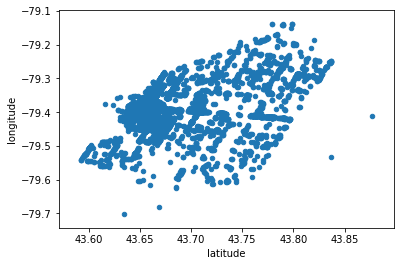

In [7]:
coordinates = df_biz[['latitude', 'longitude']]
coordinates.plot.scatter('latitude','longitude')

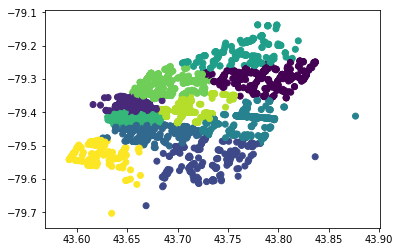

In [8]:
from sklearn.cluster import KMeans

clf = KMeans(n_clusters=10)
clf.fit(coordinates)
coordinates_clusters = clf.labels_
plt.scatter(x = coordinates['latitude'], y = coordinates['longitude'], c=coordinates_clusters)

# Collaborative Filtering - Rating Prediction

In [9]:
from surprise import SVD, SVDpp, CoClustering, SlopeOne, KNNBasic, KNNWithZScore

from surprise import Dataset, Reader, accuracy
from surprise.model_selection import cross_validate as surprise_cv, GridSearchCV as surprise_grid_search_cv, train_test_split as surprise_test_train_split

df_surprise = df_reviews[['business_id', 'user_id', 'rating']]
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(df_surprise, reader)
algo = SVD()

# surprise_cv(algo, data, measures=['RMSE', 'MAE', 'fcp'], cv=3, verbose=3, n_jobs=3)

In [10]:
trainset, testset = surprise_test_train_split(data, test_size=.25)
algo.fit(trainset)
predictions = algo.test(testset)
print(accuracy.fcp(predictions, verbose=True), accuracy.mae(predictions, verbose=True))

FCP:  0.5799
MAE:  0.8251
0.5799025256877353 0.8250721232052296


In [11]:
predictions[:2]

[Prediction(uid='dp9haMgS5RZ6i1kQq_oS5A', iid='yK2DNU5zEy9GjEYuUuaXeQ', r_ui=5.0, est=3.5152335044772176, details={'was_impossible': False}),
 Prediction(uid='bsFZnc2mYyGy5cFf5EWTWg', iid='YVaONBBT9lSJQwBPWCB0qQ', r_ui=3.0, est=2.7701672369248174, details={'was_impossible': False})]

# Baseline Binary Prediction - Collaborative Filtering

In [12]:
from networkx.algorithms import bipartite

g = nx.Graph()
g.add_nodes_from(df_users.user_id.unique(), bipartite=0)
g.add_nodes_from(df_biz.business_id.unique(), bipartite=1)

g.add_edges_from([(user, business) for user, business
                           in zip(df_reviews.user_id, df_reviews.business_id)])

In [13]:
binary_data = bipartite.biadjacency_matrix(g, df_users.user_id.unique()).todense()
df_binary = pd.DataFrame(binary_data)
df_binary['user_id'] = df_binary.index.values
df_binary.head(3)

,0,1,2,3,4,5,6,7,8,9,...,7954,7955,7956,7957,7958,7959,7960,7961,7962,user_id
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [14]:
df_binary = pd.melt(df_binary, id_vars='user_id')
df_binary.rename({'variable':'business_id', 'value':'has_reviewed'}, axis='columns', inplace=True)

In [15]:
df_binary

,user_id,business_id,has_reviewed
0,0,0,0
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,0
...,...,...,...
149736247,18799,7962,0
149736248,18800,7962,0
149736249,18801,7962,0
149736250,18802,7962,0


In [16]:
def negative_sampling(df, ratio_zeros_on_ones):
    df_zeros = df_binary.loc[df_binary['has_reviewed'] == 0]
    df_ones = df_binary.loc[df_binary['has_reviewed'] != 0]
    df_zeros = df_zeros.sample(n=int(df_ones.shape[0]*ratio_zeros_on_ones))
    return pd.concat([df_zeros, df_ones]).sample(frac=1).reset_index(drop=True)

In [17]:
reader = Reader(rating_scale=(0, 1))

In [18]:
pd.read_csv('results_grid_search_1.csv')

,Unnamed: 0,algo,ratio,fcp,mae
0,0,<surprise.prediction_algorithms.matrix_factori...,1,0.685010,0.299105
1,1,<surprise.prediction_algorithms.matrix_factori...,1,0.693832,0.287712
2,2,<surprise.prediction_algorithms.co_clustering....,1,0.662593,0.254488
3,3,<surprise.prediction_algorithms.slope_one.Slop...,1,0.671566,0.320343
4,4,<surprise.prediction_algorithms.knns.KNNBasic ...,1,0.696282,0.366031
5,5,<surprise.prediction_algorithms.knns.KNNWithZS...,1,0.687305,0.295729
6,6,<surprise.prediction_algorithms.matrix_factori...,3,0.736513,0.236169
7,7,<surprise.prediction_algorithms.matrix_factori...,3,0.753481,0.229350
8,8,<surprise.prediction_algorithms.co_clustering....,3,0.738933,0.208497
9,9,<surprise.prediction_algorithms.slope_one.Slop...,3,0.742451,0.226969


In [19]:
data = negative_sampling(df_binary, 1)
print(data.shape)
data = Dataset.load_from_df(data, reader)

(441456, 3)


In [20]:
pd.read_csv('results_grid_search_2.csv').columns

Index(['Unnamed: 0', 'split0_test_mae', 'split0_train_mae', 'split1_test_mae',
       'split1_train_mae', 'split2_test_mae', 'split2_train_mae',
       'split3_test_mae', 'split3_train_mae', 'split4_test_mae',
       'split4_train_mae', 'mean_test_mae', 'std_test_mae', 'mean_train_mae',
       'std_train_mae', 'rank_test_mae', 'split0_test_fcp', 'split0_train_fcp',
       'split1_test_fcp', 'split1_train_fcp', 'split2_test_fcp',
       'split2_train_fcp', 'split3_test_fcp', 'split3_train_fcp',
       'split4_test_fcp', 'split4_train_fcp', 'mean_test_fcp', 'std_test_fcp',
       'mean_train_fcp', 'std_train_fcp', 'rank_test_fcp', 'mean_fit_time',
       'std_fit_time', 'mean_test_time', 'std_test_time', 'params',
       'param_n_factors', 'param_n_epochs', 'param_init_mean', 'param_lr_all',
       'param_reg_all'],
      dtype='object')

In [21]:
algo = SVD()

trainset, testset = surprise_test_train_split(data, test_size=.25)
algo.fit(trainset)

predictions = algo.test(testset)
print(accuracy.fcp(predictions, verbose=True), accuracy.mae(predictions, verbose=True))

FCP:  0.6825
MAE:  0.2982
0.6824636910439429 0.29815005284656004


In [22]:
from helpers import get_top_n

top_pred = get_top_n(predictions, n=1)
user_ids = list(top_pred.keys())
business_ids = [top_pred[0][0] for top_pred in list(top_pred.values())]

In [23]:
df_top_pred_test = pd.DataFrame({'user_id':user_ids, 'business_id':business_ids})
df_top_pred_test.head(3)

,user_id,business_id
0,4661,1097
1,3331,3730
2,441,4037


In [24]:
df_top_pred_test = pd.merge(df_top_pred_test,df_binary, how='left', on=['user_id','business_id'])
df_top_pred_test.head(3)

,user_id,business_id,has_reviewed
0,4661,1097,1
1,3331,3730,1
2,441,4037,1


In [28]:
print('precision of top 1 recommender: {}'.format(df_top_pred_test['has_reviewed'].mean()))
print('Note that a random recommender would have a precision of : {}'.format(df_binary['has_reviewed'].mean()))

precision of top 1 recommender: 0.5732477202827388
Note that a random recommender would have a precision of : 0.001474111960542461


# Binary Prediction - Using Graph Analysis
- Community detection
    - User --[Friends]-->User
    - User --[Reviewed]-->Restaurant
    - User --[Friends]-->User & User --[Reviewed]-->Restaurant
- Centrality measures on restaurants

In [ ]:
from graph import *
g_friends = make_friends_graph()
g_bipartite = make_user_business_bipartite_graph(weighted=False, minimum_rating=4)
g_full = make_frienships_and_reviews_graph(weight_ratio=1, minimum_rating=0)

In [ ]:
import itertools
from networkx.algorithms.community.centrality import girvan_newman
partitions_gn = girvan_newman(g_friends)

In [ ]:
plot_dendrogram(g_friends, partitions_gn)

In [ ]:
x = []
y = []
for i, part in ennumerate(sorted(partitions_gn[10],reverse=True, key=len)):
    x.append(i)
    y.append(len(part))
y = y / sum(y)
    
plt.scatter(x=x, y=y)
plt.show()

In [ ]:
users = []
communities = []
for i, part in ennumerate(sorted(partitions_gn[10],reverse=True, key=len)):
    for user in part:
        users.append(user)
        communities.append(i)
        

